# Goal: Classify vehicle as bus or car based on smartphone sensor data

In [52]:
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
%matplotlib inline

#### Load the processed sensor data for car trip (see "Process Smartphone Sensor Data" jupyter notebook).  On this trip, I drove my car from home to Censio and back and used SensorLog on my iPhone to track the trip.  The total time for the trip was about 15 minutes.

In [20]:
dfcar = pd.read_csv('../Data/shaneiphone_exp2_processed.csv', index_col='DateTime')

#### Load the processed sensor data for bus trip (see "Process Smartphone Sensor Data" jupyter notebook).  On this trip, I took the 47 bus for about 10 minutes.

In [21]:
dfbus = pd.read_csv('../Data/shanebus20150827_processed.csv', index_col='DateTime')

In [22]:
# combine into a single dataframe
df = pd.concat([dfcar, dfbus])

In [38]:
# Use only userAcceleration and gyroscope data, since these features are expected to generalize well.
xyz = ['X', 'Y', 'Z']
measures = ['userAcceleration', 'gyroscope']
basefeatures = [i + j for i in measures for j in xyz]
features = [i + j for i in measures for j in xyz]

In [39]:
# Add Gaussian smoothed features
smoothfeatures = []
for i in features:
    df[i + 'sm'] = gaussian_filter(df[i], 3)
    df[i + '2sm'] = gaussian_filter(df[i], 100)
    smoothfeatures.append(i + 'sm')
    smoothfeatures.append(i + '2sm')
features.extend(smoothfeatures)

In [40]:
# Generate Jerk signal
jerkfeatures = []
for i in features:
    diffsignal = np.diff(df[i])
    df[i + 'jerk'] = np.append(0, diffsignal)
    jerkfeatures.append(i + 'jerk')
features.extend(jerkfeatures)

In [41]:
# assign class labels
car0 = (df.index > '2015-08-25 14:35:00') & \
        (df.index <= '2015-08-25 14:42:00')

car1 = (df.index > '2015-08-25 14:43:00') & \
        (df.index <= '2015-08-25 14:48:00')

bus0 = (df.index > '2015-08-27 10:10:00') & \
        (df.index <= '2015-08-27 10:15:00')
bus1 = (df.index > '2015-08-27 10:15:00') & \
        (df.index <= '2015-08-27 10:20:00')

nc = len(df)
df['class'] = np.zeros(nc) - 1
df['class'][car0] = np.zeros(nc)
df['class'][car1] = np.zeros(nc)
df['class'][bus0] = np.ones(nc)
df['class'][bus1] = np.ones(nc)

In [42]:
# separate into quarters for train and validation
q1 = df[car0]
q2 = df[car1]
q3 = df[bus0]
q4 = df[bus1]
traindf = pd.concat([q2, q4])
validationdf = pd.concat([q1, q3])

In [43]:
# check for NaNs in the dataframes
print(traindf.isnull().sum().sum())
print(validationdf.isnull().sum().sum())

0
0


In [44]:
# drop NaNs
traindf = traindf.dropna()
validationdf = validationdf.dropna()

In [45]:
# Make the training and validation sets
X_train = traindf[features].values
y_train = traindf['class'].values
X_test = validationdf[features].values
y_test = validationdf['class'].values

In [46]:
# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [47]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

(array([ 0.67006308,  0.63221737,  0.60436893,  0.68479845,  0.85769791]), 0.68982914717583199, 0.088564657518697895)


In [48]:
# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)

In [49]:
# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.654


#### We're not overfitting the data, but we're also not really predicting the vehicle class very well, since we're only right about 65-70% of the time with any prediction we make.

In [50]:
# Inspect feature importances
for i, ifeature in enumerate(features):
    print(ifeature + ': %6.4f' % clf.feature_importances_[i])

userAccelerationX: 0.0022
userAccelerationY: 0.0013
userAccelerationZ: 0.0016
gyroscopeX: 0.0033
gyroscopeY: 0.0050
gyroscopeZ: 0.0416
userAccelerationXsm: 0.0141
userAccelerationX2sm: 0.0390
userAccelerationYsm: 0.0071
userAccelerationY2sm: 0.0619
userAccelerationZsm: 0.0036
userAccelerationZ2sm: 0.0508
gyroscopeXsm: 0.0117
gyroscopeX2sm: 0.0495
gyroscopeYsm: 0.0384
gyroscopeY2sm: 0.0840
gyroscopeZsm: 0.1003
gyroscopeZ2sm: 0.1531
userAccelerationXjerk: 0.0012
userAccelerationYjerk: 0.0008
userAccelerationZjerk: 0.0019
gyroscopeXjerk: 0.0018
gyroscopeYjerk: 0.0015
gyroscopeZjerk: 0.0220
userAccelerationXsmjerk: 0.0018
userAccelerationX2smjerk: 0.0209
userAccelerationYsmjerk: 0.0019
userAccelerationY2smjerk: 0.0550
userAccelerationZsmjerk: 0.0016
userAccelerationZ2smjerk: 0.0227
gyroscopeXsmjerk: 0.0089
gyroscopeX2smjerk: 0.0329
gyroscopeYsmjerk: 0.0111
gyroscopeY2smjerk: 0.0609
gyroscopeZsmjerk: 0.0299
gyroscopeZ2smjerk: 0.0545


#### The smoothed gyroscopeZ data is the most useful feature.

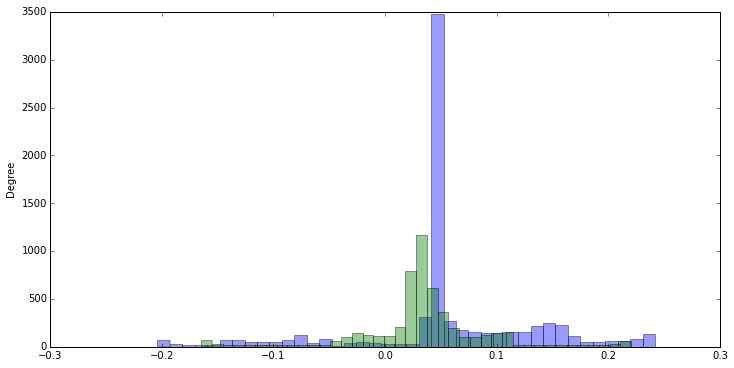

In [60]:
# compare bus gyroscopeZ2sm and car gyroscopeZ2sm
q1['gyroscopeZ2sm'].plot(color='blue', figsize=(12,6), kind='hist', bins=40, alpha=0.4) # car
q3['gyroscopeZ2sm'].plot(color='green', kind='hist', bins=40, alpha=0.4) # bus

#### Reflecting on this further, it occurs to me that this methodology is identifying that the bus trip and the car trip followed different routes and had different numbers and types of turns.  A better way to go might be to identify features for each turn (e.g., time to complete turn, average accelerometer and gyroscope signal during turn, etc.) and apply the random forest to those features.

#### Another interesting avenue to pursue is features in Fourier space

In [61]:
# Generate Fourier Transform of features
fftfeatures = []
for i in features:
    reals = np.real(np.fft.rfft(df[i]))
    imags = np.imag(np.fft.rfft(df[i]))
    complexs = [reals[0]]
    n = len(reals)
    if n % 2 == 0:
        complexs.append(imags[0])
    for j in range(1, n - 1):
        complexs.append(reals[j])
        complexs.append(imags[j])
    complexs.append(reals[j])
    df['f' + i] = complexs
    fftfeatures.append('f' + i)
features.extend(fftfeatures)

In [62]:
# Make the training and validation sets
X_train = traindf[fftfeatures].values
y_train = traindf['class'].values
X_test = validationdf[fftfeatures].values
y_test = validationdf['class'].values

In [63]:
# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [64]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

(array([ 1.,  1.,  1.,  1.,  1.]), 1.0, 0.0)


In [65]:
# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)

In [66]:
# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.868


#### Much better accuracy on the test set: 87%.  We are definitely overfitting here, since we got 100% accuracy on the training set.  We are also probably suffering from the same problem using the time series data, where the classifier learns to classify based on the nature of the route, not the nature of the ride.

In [68]:
# Inspect feature importances
for i, ifeature in enumerate(fftfeatures):
    print(ifeature + ': %6.4f' % clf.feature_importances_[i])

fuserAccelerationX: 0.0003
fuserAccelerationY: 0.0004
fuserAccelerationZ: 0.0000
fgyroscopeX: 0.0004
fgyroscopeY: 0.0002
fgyroscopeZ: 0.0008
fuserAccelerationXsm: 0.0455
fuserAccelerationX2sm: 0.0199
fuserAccelerationYsm: 0.1113
fuserAccelerationY2sm: 0.0253
fuserAccelerationZsm: 0.0360
fuserAccelerationZ2sm: 0.0183
fgyroscopeXsm: 0.0570
fgyroscopeX2sm: 0.0431
fgyroscopeYsm: 0.0558
fgyroscopeY2sm: 0.0355
fgyroscopeZsm: 0.0509
fgyroscopeZ2sm: 0.0615
fuserAccelerationXjerk: 0.0004
fuserAccelerationYjerk: 0.0002
fuserAccelerationZjerk: 0.0002
fgyroscopeXjerk: 0.0006
fgyroscopeYjerk: 0.0004
fgyroscopeZjerk: 0.0002
fuserAccelerationXsmjerk: 0.0381
fuserAccelerationX2smjerk: 0.0000
fuserAccelerationYsmjerk: 0.1315
fuserAccelerationY2smjerk: 0.0001
fuserAccelerationZsmjerk: 0.0069
fuserAccelerationZ2smjerk: 0.0000
fgyroscopeXsmjerk: 0.0480
fgyroscopeX2smjerk: 0.0001
fgyroscopeYsmjerk: 0.0607
fgyroscopeY2smjerk: 0.0001
fgyroscopeZsmjerk: 0.1500
fgyroscopeZ2smjerk: 0.0002


#### Interesting that the accelerometer signal is more important here.  This could be an indication that training in Fourier space helps mitigate the route-based issues that we encountered when using the time series data.